<a href="https://colab.research.google.com/github/LigandBindingDomain/Decoding_Bias/blob/main/ELO_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup

from __future__ import annotations
!pip install fuzzywuzzy
# Install required packages if not already installed
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import scipy.stats as stats
    from tqdm import tqdm
    from fuzzywuzzy import process
    from dataclasses import dataclass
    from collections import defaultdict
    from typing import Dict, Optional, List, Tuple
except ImportError:
    print("Installing required packages...")
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import os
import logging
from fuzzywuzzy import process
from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, Optional, List, Tuple
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Set up matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Create directories
base_dir = "elo_analysis_results"
log_dir = os.path.join(base_dir, "logs_UTD_elo")
results_dir = os.path.join(base_dir, "UTD_elo")
figure_dir = os.path.join(base_dir, "figures_UTD_elo")
species_analysis_dir = os.path.join(base_dir, "species_analysis_UTD_elo")

for directory in [base_dir, log_dir, results_dir, figure_dir, species_analysis_dir]:
    os.makedirs(directory, exist_ok=True)

print("Setup complete. Directories created at:", base_dir)

Setup complete. Directories created at: elo_analysis_results


# Core Functions

In [ ]:
#@title Normalize

def normalize_scores(data: pd.DataFrame, score_columns: List[str], protein_column: str = 'protein_name') -> pd.DataFrame:
    """Normalize scores within each protein group

    This function converts raw scores to z-scores (standard scores) within each protein group,
    allowing for fair comparison across different proteins.

    Parameters:
    -----------
    data: pd.DataFrame
        Input data containing protein scores
    score_columns: List[str]
        List of column names containing model scores
    protein_column: str
        Name of the column containing protein identifiers

    Returns:
    --------
    pd.DataFrame
        Data with normalized score columns added
    """
    normalized_data = data.copy()


    for col in score_columns:
        # Skip columns that don't exist
        if col not in normalized_data.columns:
            logging.warning(f"Column {col} not found in data, skipping normalization")
            continue

        # Create a new column with the normalized score
        normalized_col = f"{col}_score" if not col.endswith('_score') else col

        # Group by protein and normalize scores
        group = normalized_data.groupby(protein_column)[col]
        normalized_data[normalized_col] = group.transform(lambda x: (x - x.mean()) / (x.std() or 1.0))

        # Log the normalization results
        logging.info(f"Normalized {col} -> {normalized_col}")
        logging.info(f"  Original range: [{normalized_data[col].min():.2f}, {normalized_data[col].max():.2f}]")
        logging.info(f"  Normalized range: [{normalized_data[normalized_col].min():.2f}, {normalized_data[normalized_col].max():.2f}]")

    return normalized_data

In [ ]:
#@title StandardEloRater
import logging
from collections import defaultdict
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

SEED = 42          # master seed (change if you want a new RNG stream)
TOL  = 1e-8        # z-score difference regarded as a tie

rng_global = np.random.default_rng(SEED)  # global RNG; avoid np.random.seed()

# ── K-factor strategies ────────────────────────────────────────────────────────
class KStrategy:
    """Base class – implement __call__(rating, matches_played) → K."""
    def __call__(self, rating: float, matches_played: int) -> float:  # pragma: no cover
        raise NotImplementedError


class FixedK(KStrategy):
    def __init__(self, K: int = 32) -> None:
        self.K = K

    def __call__(self, rating: float, matches_played: int) -> float:
        return self.K


class DecayK(KStrategy):
    """Example of a decaying-K schedule (optional)."""
    def __init__(self, K0: int = 40, K_min: int = 10, halftime: int = 400) -> None:
        """
        Parameters
        ----------
        K0       : Starting K value for an unrated species.
        K_min    : Floor value K approaches as matches grow.
        halftime : Matches needed for K to halve from K0 toward K_min.
        """
        self.K0, self.K_min, self.halftime = K0, K_min, halftime

    def __call__(self, rating: float, matches_played: int) -> float:
        return self.K_min + (self.K0 - self.K_min) * 0.5 ** (matches_played / self.halftime)


# ── Elo rater ──────────────────────────────────────────────────────────────────
class StandardEloRater:
    """Elo engine that supports arbitrary K strategies **and** quality weights."""
    def __init__(
        self,
        k_strategy: Optional[KStrategy] = None,
        initial_rating: float = 1500.0,
        lower: float = 100.0,
        upper: float = 3000.0,
    ) -> None:
        self.k_strategy: KStrategy = k_strategy or FixedK(32)
        self.initial_rating = initial_rating
        self.lower, self.upper = lower, upper
        self.ratings: Dict[str, float] = defaultdict(lambda: self.initial_rating)
        self.matches: Dict[str, int] = defaultdict(int)

    def update_rating(
        self,
        player_a: str,
        player_b: str,
        score_a: float,
        quality_weight: float = 1.0,
    ) -> Tuple[float, float]:
        """Update ratings with an optional multiplicative quality weight (0–1]."""
        r_a, r_b = self.ratings[player_a], self.ratings[player_b]
        k_a = self.k_strategy(r_a, self.matches[player_a]) * quality_weight
        k_b = self.k_strategy(r_b, self.matches[player_b]) * quality_weight

        exp_a = 1.0 / (1.0 + 10.0 ** ((r_b - r_a) / 400.0))
        delta = score_a - exp_a

        r_a_new = np.clip(r_a + k_a * delta, self.lower, self.upper)
        r_b_new = np.clip(r_b - k_b * delta, self.lower, self.upper)

        self.ratings[player_a], self.ratings[player_b] = r_a_new, r_b_new
        self.matches[player_a] += 1
        self.matches[player_b] += 1
        return r_a_new, r_b_new

# ── Main function – now passes quality weights ────────────────────────────────
def compute_elo_ratings(
    data: pd.DataFrame,
    score_column: str,
    protein_column: str = "protein_name",
    species_column: str = "species",
    plddt_column: str = "avg_plddt",          # NEW
    n_permutations: int = 10,
    min_species_per_protein: int = 2,
    k_strategy: Optional[KStrategy] = None,
    seed: int = SEED,
    tol: float = TOL,
) -> Dict[str, Dict[str, float]]:
    """
    Compute quality-weighted Elo ratings for species.
    Every match is down-weighted by √(pLDDTᵢ · pLDDTⱼ) / 100.
    """
    # 1 — validation
    required = {score_column, species_column, protein_column, plddt_column}
    missing  = required - set(data.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = data.dropna(subset=list(required)).copy()
    if df.empty:
        raise ValueError("No valid data after dropping NaNs.")

    ok_proteins = (
        df.groupby(protein_column)[species_column]
          .nunique()
          .loc[lambda s: s >= min_species_per_protein]
          .index
    )
    logging.info("Found %d proteins with ≥%d species", len(ok_proteins), min_species_per_protein)

    # 2 — loop over permutations
    all_ratings: Dict[str, List[float]] = defaultdict(list)
    rng = np.random.default_rng(seed)
    k_strategy = k_strategy or FixedK(32)

    for perm_idx in tqdm(range(n_permutations), desc=f"Elo on {score_column}"):
        elo = StandardEloRater(k_strategy=k_strategy)
        for protein in rng.permutation(ok_proteins):
            agg = (
                df.loc[df[protein_column] == protein,
                       [species_column, score_column, plddt_column]]
                  .groupby(species_column)
                  .agg(score=(score_column, "median"),
                       qual =(plddt_column, "mean"))
            )
            ids   = agg.index.to_numpy()
            scores= agg["score"].to_numpy()
            quals = agg["qual"].to_numpy()

            idx_i, idx_j = np.triu_indices(len(ids), k=1)
            for i, j in zip(idx_i, idx_j):
                diff = scores[i] - scores[j]
                s_a  = 0.5 if abs(diff) < tol else float(diff > 0.0)

                # geometric-mean quality weight in [0,1]
                w = (quals[i] * quals[j]) / 10000.0      # (p_i /100) * (p_j /100)
                w = np.clip(w, 0.01, 1.0)       # avoid weight=0
                elo.update_rating(ids[i], ids[j], s_a, quality_weight=w)

        for sp, r in elo.ratings.items():
            all_ratings[sp].append(r)

        rng = np.random.default_rng(seed + perm_idx + 1)

    # 3 — aggregate across permutations
    final: Dict[str, Dict[str, float]] = {}
    for sp, arr in all_ratings.items():
        arr = np.asarray(arr, dtype=float)
        final[sp] = {
            "rating"  : float(arr.mean()),
            "std_err" : float(arr.std(ddof=1) / np.sqrt(len(arr))),
            "ci_lower": float(np.percentile(arr, 2.5)),
            "ci_upper": float(np.percentile(arr, 97.5)),
        }
    return final

In [ ]:

#@title Stats
def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_se

def calculate_domain_statistics(df):
    """Calculate comprehensive domain-level statistics for each model"""
    stats_by_model = {}

    for model in df['model'].unique():
        model_df = df[df['model'] == model]

        # Calculate basic statistics
        domain_stats = model_df.groupby('domain').agg({
            'rating': ['count', 'mean', 'std', 'sem'],
            'ci_lower': 'mean',
            'ci_upper': 'mean'
        }).round(2)

        # Perform ANOVA between domains
        domain_groups = [group['rating'].values for name, group in model_df.groupby('domain')]
        if len(domain_groups) >= 2 and all(len(g) > 0 for g in domain_groups):
            f_stat, p_val = stats.f_oneway(*domain_groups)
        else:
            f_stat, p_val = float('nan'), float('nan')

        # Calculate effect sizes between domains
        domains = model_df['domain'].unique()
        effect_sizes = []
        for i in range(len(domains)):
            for j in range(i + 1, len(domains)):
                d1, d2 = domains[i], domains[j]
                group1 = model_df[model_df['domain'] == d1]['rating']
                group2 = model_df[model_df['domain'] == d2]['rating']
                if len(group1) > 0 and len(group2) > 0:
                    cohens_d = calculate_cohens_d(group1, group2)
                    effect_sizes.append({
                        'comparison': f'{d1} vs {d2}',
                        'cohens_d': cohens_d
                    })

        stats_by_model[model] = {
            'domain_stats': domain_stats,
            'anova': {'f_statistic': f_stat, 'p_value': p_val},
            'effect_sizes': effect_sizes
        }

    return stats_by_model

def calculate_model_correlations(df):
    """Calculate correlations between different models' ELO ratings"""
    correlation_results = {}
    models = df['model'].unique()

    # Create pivot table for correlations
    pivot_df = df.pivot(index='species', columns='model', values='rating')

    # Calculate correlations and p-values
    correlations = pivot_df.corr()
    p_values = pd.DataFrame(index=models, columns=models)

    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            model1, model2 = models[i], models[j]
            common_species = pivot_df[[model1, model2]].dropna()
            if len(common_species) >= 2:
                corr, p_val = stats.pearsonr(
                    common_species[model1],
                    common_species[model2]
                )
                p_values.loc[model1, model2] = p_val
                p_values.loc[model2, model1] = p_val
            else:
                p_values.loc[model1, model2] = float('nan')
                p_values.loc[model2, model1] = float('nan')

    correlation_results['correlations'] = correlations
    correlation_results['p_values'] = p_values

    return correlation_results

In [ ]:

#@title Plots
def plot_elo_distribution(df, output_dir, baseline_rating=1500):
    """Create visualization of Elo ratings distribution by domain for each model"""
    # Create a plot for each model
    for model in df['model'].unique():
        plt.figure(figsize=(12, 8))

        # Filter data for this model
        model_df = df[df['model'] == model].copy()

        # Calculate differences from baseline
        model_df['rating_diff'] = model_df['rating'] - baseline_rating

        # Define domain colors
        domain_colors = {
            'Bacteria': '#3498db',
            'bacteria': '#3498db',
            'Archaea': '#e74c3c',
            'archaea': '#e74c3c',
            'Eukaryota': '#2ecc71',
            'eukarya': '#2ecc71'
        }

        # Convert 'domain' column to title case for display
        model_df['domain_display'] = model_df['domain'].str.title()

        # Sort by rating
        df_sorted = model_df.sort_values('rating_diff')

        # Create bar plot
        colors = [domain_colors.get(d, '#999999') for d in df_sorted['domain']]
        bars = plt.bar(
            range(len(df_sorted)),
            df_sorted['rating_diff'],
            color=colors,
            alpha=0.7
        )

        # Add baseline line
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

        # Add domain means
        for domain in sorted(df_sorted['domain'].unique()):
            domain_subset = df_sorted[df_sorted['domain'] == domain]
            if not domain_subset.empty:
                domain_mean = domain_subset['rating_diff'].mean()
                plt.axhline(y=domain_mean,
                           color=domain_colors.get(domain, '#999999'),
                           linestyle='--',
                           alpha=0.8,
                           label=f'{domain.title()} Mean')

        # Customize plot
        plt.title(f'{model.upper()}\nElo Rating Differences from Baseline', pad=20, fontsize=14)
        plt.ylabel('Difference from Baseline Rating (1500)', fontsize=12)
        plt.xlabel('Species', fontsize=12)
        plt.xticks([])
        plt.legend(title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, axis='y', alpha=0.3)

        # Ensure y-axis is symmetric around 0
        y_max = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))
        plt.ylim(-y_max, y_max)

        plt.tight_layout()

        # Save plot
        output_path = os.path.join(output_dir, f'{model}_elo_ratings_distribution.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()

    return output_dir

def plot_model_correlations(correlation_results, output_dir):
    """Create heatmap of model correlations"""
    plt.figure(figsize=(10, 8))

    # Plot correlation heatmap
    sns.heatmap(
        correlation_results['correlations'],
        annot=True,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        fmt='.2f'
    )

    plt.title('Model Rating Correlations', fontsize=14)
    plt.tight_layout()

    # Save plot
    output_path = os.path.join(output_dir, 'model_correlations_heatmap.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

In [ ]:
#@title Species Rep

def analyze_species_representation(
    input_data: pd.DataFrame,
    pdb_counts: pd.DataFrame,
    elo_results: pd.DataFrame,
    output_dir: str,
    fuzzy_match_threshold: int = 90
):
    """Analyze the relationship between species representation and ELO ratings.

    Parameters:
    -----------
    input_data: pd.DataFrame
        Input data containing protein information and scores
    pdb_counts: pd.DataFrame
        DataFrame with species counts from PDB
    elo_results: pd.DataFrame
        DataFrame with ELO ratings for each species and model
    output_dir: str
        Directory to save results
    fuzzy_match_threshold: int
        Threshold for fuzzy matching species names (0-100)

    Returns:
    --------
    tuple:
        (merged_analysis, correlation_df) - DataFrames with analysis results
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Normalize column names in PDB counts DataFrame
    if 'species' not in pdb_counts.columns and 'species' in pdb_counts.columns:
        pdb_counts = pdb_counts.rename(columns={'species': 'species'})

    if 'Number_of_Entries' not in pdb_counts.columns:
        # Try to find a column that could represent entry counts
        possible_count_cols = [col for col in pdb_counts.columns if 'entries' in col.lower() or 'count' in col.lower() or 'number' in col.lower()]
        if possible_count_cols:
            pdb_counts = pdb_counts.rename(columns={possible_count_cols[0]: 'Number_of_Entries'})
        else:
            logging.error("Cannot find a column for PDB entry counts. Please check the PDB counts file.")
            return None, None

    # Step 1: Calculate species representation in the input dataset
    logging.info("Calculating species representation in the input dataset")
    species_counts = input_data['species'].value_counts().reset_index()
    species_counts.columns = ['species', 'dataset_entries']

    # Calculate percentage of total entries
    total_entries = len(input_data)
    species_counts['dataset_percentage'] = (species_counts['dataset_entries'] / total_entries) * 100

    # Save the species counts to a CSV file
    species_counts_path = os.path.join(output_dir, "species_counts.csv")
    species_counts.to_csv(species_counts_path, index=False)
    logging.info(f"Saved species counts to {species_counts_path}")

    # Step 2: Match species in the dataset with species in the PDB counts
    logging.info("Matching species names between dataset and PDB counts")

    # Create a mapping between dataset species and PDB species using fuzzy matching
    dataset_species = species_counts['species'].unique()
    pdb_species = pdb_counts['species'].unique()

    species_mapping = {}
    for ds_species in dataset_species:
        best_match, score = process.extractOne(ds_species, pdb_species)
        if score >= fuzzy_match_threshold:
            species_mapping[ds_species] = best_match

    logging.info(f"Found {len(species_mapping)} matching species between dataset and PDB (threshold: {fuzzy_match_threshold})")

    # Create a DataFrame with the mapping results
    mapping_df = pd.DataFrame({
        'dataset_species': list(species_mapping.keys()),
        'pdb_species': list(species_mapping.values())
    })

    # Save the mapping to a CSV file
    mapping_path = os.path.join(output_dir, "species_name_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    logging.info(f"Saved species name mapping to {mapping_path}")

    # Step 3: Merge dataset species counts with PDB counts
    species_analysis = species_counts.copy()

    # Add the mapped PDB species names
    species_analysis['pdb_species'] = species_analysis['species'].map(species_mapping)

    # Merge with PDB counts
    species_analysis = pd.merge(
        species_analysis,
        pdb_counts[['species', 'Number_of_Entries']],
        left_on='pdb_species',
        right_on='species',
        how='left',
        suffixes=('', '_pdb')
    )

    # Rename the PDB entries column and drop the redundant column
    species_analysis = species_analysis.rename(columns={'Number_of_Entries': 'pdb_entries'})
    if 'species_pdb' in species_analysis.columns:
        species_analysis = species_analysis.drop(columns=['species_pdb'])

    # Replace NaN values in PDB entries with 0
    species_analysis['pdb_entries'] = species_analysis['pdb_entries'].fillna(0)

    # Add log-transformed counts for better visualization
    species_analysis['log_dataset_entries'] = np.log10(species_analysis['dataset_entries'] + 1)
    species_analysis['log_pdb_entries'] = np.log10(species_analysis['pdb_entries'] + 1)

    # Step 4: Merge species analysis with ELO ratings
    logging.info("Merging species representation with ELO ratings")
    merged_analysis = pd.merge(
        species_analysis,
        elo_results,
        on='species',
        how='inner'
    )

    # Save the merged analysis to a CSV file
    merged_path = os.path.join(output_dir, "species_representation_with_elo.csv")
    merged_analysis.to_csv(merged_path, index=False)
    logging.info(f"Saved merged analysis to {merged_path}")

    # Step 5: Calculate correlations between species representation and ELO ratings
    logging.info("Calculating correlations between species representation and ELO ratings")

    # Identify rating columns
    rating_cols = [col for col in merged_analysis.columns if col.startswith('rating_')]
    model_names = [col.replace('rating_', '') for col in rating_cols]

    correlation_results = []

    for model in model_names:
        rating_col = f'rating_{model}'
        if rating_col in merged_analysis.columns:
            try:
                # Clean data for correlation analysis by removing rows with NaN or Inf values
                clean_data = merged_analysis[[rating_col, 'dataset_entries', 'pdb_entries']].replace([np.inf, -np.inf], np.nan).dropna()

                if len(clean_data) < 2:
                    logging.warning(f"Not enough valid data points for {model} correlation analysis")
                    pearson_r, pearson_p = np.nan, np.nan
                    spearman_r, spearman_p = np.nan, np.nan
                    pdb_pearson_r, pdb_pearson_p = np.nan, np.nan
                    pdb_spearman_r, pdb_spearman_p = np.nan, np.nan
                else:
                    # Calculate Pearson correlation between dataset entries and rating
                    pearson_r, pearson_p = stats.pearsonr(clean_data['dataset_entries'], clean_data[rating_col])

                    # Calculate Spearman rank correlation between dataset entries and rating
                    spearman_r, spearman_p = stats.spearmanr(clean_data['dataset_entries'], clean_data[rating_col])

                    # Calculate correlations with PDB entries if available
                    if 'pdb_entries' in clean_data.columns and clean_data['pdb_entries'].sum() > 0:
                        pdb_clean_data = clean_data[['pdb_entries', rating_col]].replace([np.inf, -np.inf], np.nan).dropna()
                        if len(pdb_clean_data) >= 2:
                            pdb_pearson_r, pdb_pearson_p = stats.pearsonr(pdb_clean_data['pdb_entries'], pdb_clean_data[rating_col])
                            pdb_spearman_r, pdb_spearman_p = stats.spearmanr(pdb_clean_data['pdb_entries'], pdb_clean_data[rating_col])
                        else:
                            pdb_pearson_r, pdb_pearson_p, pdb_spearman_r, pdb_spearman_p = np.nan, np.nan, np.nan, np.nan
                    else:
                        pdb_pearson_r, pdb_pearson_p, pdb_spearman_r, pdb_spearman_p = np.nan, np.nan, np.nan, np.nan
            except Exception as e:
                logging.error(f"Error calculating correlation for {model}: {str(e)}")
                pearson_r, pearson_p = np.nan, np.nan
                spearman_r, spearman_p = np.nan, np.nan
                pdb_pearson_r, pdb_pearson_p = np.nan, np.nan
                pdb_spearman_r, pdb_spearman_p = np.nan, np.nan

            # Add correlation results
            correlation_results.append({
                'model': model,
                'dataset_entries_pearson_r': pearson_r,
                'dataset_entries_pearson_p': pearson_p,
                'dataset_entries_spearman_r': spearman_r,
                'dataset_entries_spearman_p': spearman_p,
                'pdb_entries_pearson_r': pdb_pearson_r,
                'pdb_entries_pearson_p': pdb_pearson_p,
                'pdb_entries_spearman_r': pdb_spearman_r,
                'pdb_entries_spearman_p': pdb_spearman_p
            })

    # Create a DataFrame with the correlation results
    correlation_df = pd.DataFrame(correlation_results)

    # Save the correlation results to a CSV file
    corr_path = os.path.join(output_dir, "representation_elo_correlations.csv")
    correlation_df.to_csv(corr_path, index=False)
    logging.info(f"Saved correlation results to {corr_path}")

    return merged_analysis, correlation_df

#@title Robust species matching function
def robust_species_matching(dataset_species, pdb_species, threshold=80, manual_map=None):
    """
    Returns a mapping from dataset_species to pdb_species using both exact and fuzzy matching.
    Optionally takes a manual_map dict for overrides.
    """
    mapping = {}
    pdb_species_set = set(pdb_species)
    for ds in dataset_species:
        # Exact match first
        if ds in pdb_species_set:
            mapping[ds] = ds
            continue
        # Manual override
        if manual_map and ds in manual_map:
            mapping[ds] = manual_map[ds]
            continue
        # Fuzzy match
        best, score = process.extractOne(ds, pdb_species)
        if score >= threshold:
            mapping[ds] = best
    return mapping

def plot_representation_elo_correlations(
    merged_analysis: pd.DataFrame,
    correlation_df: pd.DataFrame,
    output_dir: str
):
    """Generate visualizations of correlations between species representation and ELO ratings.

    Parameters:
    -----------
    merged_analysis: pd.DataFrame
        DataFrame with merged species representation and ELO data
    correlation_df: pd.DataFrame
        DataFrame with correlation results
    output_dir: str
        Directory to save visualizations
    """
    os.makedirs(output_dir, exist_ok=True)

    # Get model names
    rating_cols = [col for col in merged_analysis.columns if col.startswith('rating_')]
    model_names = [col.replace('rating_', '') for col in rating_cols]

    # 1. Generate scatterplots for each model showing relationship between representation and ELO rating
    for model in model_names:
        rating_col = f'rating_{model}'
        if rating_col in merged_analysis.columns:
            try:
                # Clean data for plotting
                plot_data = merged_analysis[[rating_col, 'log_dataset_entries', 'log_pdb_entries', 'domain']].copy()
                plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna(subset=[rating_col, 'log_dataset_entries'])

                if len(plot_data) < 2:
                    logging.warning(f"Not enough valid data points for {model} visualization")
                    continue

                # Plot dataset entries vs rating
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)

                # Use numerical color coding for domain
                domain_categories = plot_data['domain'].astype('category').cat.codes

                plt.scatter(
                    plot_data['log_dataset_entries'],
                    plot_data[rating_col],
                    alpha=0.7,
                    c=domain_categories,
                    cmap='viridis'
                )

                plt.xlabel('Log10(Dataset Entries)', fontsize=12)
                plt.ylabel(f'{model.upper()} ELO Rating', fontsize=12)
                plt.title(f'Dataset Representation vs {model.upper()} ELO Rating', fontsize=14)
                plt.grid(alpha=0.3)

                # Add correlation annotation
                model_corr = correlation_df[correlation_df['model'] == model]
                if not model_corr.empty and not np.isnan(model_corr['dataset_entries_pearson_r'].values[0]):
                    r = model_corr['dataset_entries_pearson_r'].values[0]
                    p = model_corr['dataset_entries_pearson_p'].values[0]
                    plt.annotate(
                        f'Pearson r: {r:.3f} (p: {p:.3e})',
                        xy=(0.05, 0.95),
                        xycoords='axes fraction',
                        fontsize=10,
                        backgroundcolor='white',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
                    )

                # Plot PDB entries vs rating if data available
                plt.subplot(1, 2, 2)

                if 'pdb_entries' in merged_analysis.columns:
                    pdb_plot_data = plot_data.dropna(subset=['log_pdb_entries'])

                    if len(pdb_plot_data) >= 2:
                        plt.scatter(
                            pdb_plot_data['log_pdb_entries'],
                            pdb_plot_data[rating_col],
                            alpha=0.7,
                            c=pdb_plot_data['domain'].astype('category').cat.codes,
                            cmap='viridis'
                        )

                        plt.xlabel('Log10(PDB Entries)', fontsize=12)
                        plt.ylabel(f'{model.upper()} ELO Rating', fontsize=12)
                        plt.title(f'PDB Representation vs {model.upper()} ELO Rating', fontsize=14)
                        plt.grid(alpha=0.3)

                        # Add correlation annotation
                        if not model_corr.empty and not np.isnan(model_corr['pdb_entries_pearson_r'].values[0]):
                            r = model_corr['pdb_entries_pearson_r'].values[0]
                            p = model_corr['pdb_entries_pearson_p'].values[0]
                            plt.annotate(
                                f'Pearson r: {r:.3f} (p: {p:.3e})',
                                xy=(0.05, 0.95),
                                xycoords='axes fraction',
                                fontsize=10,
                                backgroundcolor='white',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
                            )
                    else:
                        plt.text(0.5, 0.5, 'Insufficient data for PDB correlation plot',
                                ha='center', va='center', fontsize=12)
                else:
                    plt.text(0.5, 0.5, 'No PDB data available',
                            ha='center', va='center', fontsize=12)

                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{model}_representation_vs_elo.png"), dpi=300, bbox_inches='tight')
                plt.close()

            except Exception as e:
                logging.error(f"Error creating plot for {model}: {str(e)}")
                plt.close()

    # 2. Create heatmap of correlation coefficients
    if len(correlation_df) > 0:
        try:
            # Filter out NaN values
            valid_correlations = correlation_df.dropna(subset=['dataset_entries_pearson_r']).copy()

            if len(valid_correlations) > 0:
                correlation_heatmap_data = pd.DataFrame({
                    'Model': valid_correlations['model'].str.upper(),
                    'Dataset Pearson': valid_correlations['dataset_entries_pearson_r'],
                    'Dataset Spearman': valid_correlations['dataset_entries_spearman_r']
                })

                if 'pdb_entries_pearson_r' in valid_correlations.columns:
                    valid_pdb = valid_correlations.dropna(subset=['pdb_entries_pearson_r'])
                    if len(valid_pdb) > 0:
                        correlation_heatmap_data['PDB Pearson'] = valid_correlations['pdb_entries_pearson_r']
                        correlation_heatmap_data['PDB Spearman'] = valid_correlations['pdb_entries_spearman_r']

                correlation_heatmap_data = correlation_heatmap_data.set_index('Model')

                plt.figure(figsize=(10, 8))
                sns.heatmap(
                    correlation_heatmap_data,
                    annot=True,
                    cmap='coolwarm',
                    center=0,
                    vmin=-1,
                    vmax=1,
                    fmt='.3f'
                )
                plt.title('Correlation between Species Representation and ELO Ratings', fontsize=14)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, "representation_correlation_heatmap.png"), dpi=300, bbox_inches='tight')
                plt.close()
            else:
                logging.warning("No valid correlation data for heatmap visualization")
        except Exception as e:
            logging.error(f"Error creating correlation heatmap: {str(e)}")
            plt.close()
def analyze_domain_representation_bias(merged_analysis, output_dir):
    """Analyze potential bias in ELO ratings based on taxonomic domain representation.

    Parameters:
    -----------
    merged_analysis: pd.DataFrame
        The merged analysis DataFrame containing species representation and ELO ratings
    output_dir: str
        Directory to save analysis results
    """
    if merged_analysis is None or merged_analysis.empty:
        logging.error("No merged analysis data available for domain bias analysis.")
        return

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Calculate domain-level statistics
    logging.info("Analyzing taxonomic domain representation bias")

    try:
        # Handle potential missing domains
        if 'domain' not in merged_analysis.columns:
            logging.error("Domain column not found in merged analysis")
            return

        # Make sure merged_analysis is clean
        clean_analysis = merged_analysis.replace([np.inf, -np.inf], np.nan)

        # Calculate representation statistics by domain
        agg_dict = {'dataset_entries': ['count', 'sum', 'mean', 'median']}
        if 'pdb_entries' in clean_analysis.columns:
            agg_dict['pdb_entries'] = ['sum', 'mean', 'median']

        domain_stats = clean_analysis.groupby('domain').agg(agg_dict).round(2)

        # Save domain statistics to CSV
        domain_stats_path = os.path.join(output_dir, "domain_representation_stats.csv")
        domain_stats.to_csv(domain_stats_path)
        logging.info(f"Saved domain representation statistics to {domain_stats_path}")

        # Step 2: Calculate average ratings by domain for each model
        rating_cols = [col for col in clean_analysis.columns if col.startswith('rating_')]

        if not rating_cols:
            logging.error("No rating columns found in merged analysis")
            return

        # Calculate average ratings by domain for each model
        domain_ratings = clean_analysis.groupby('domain')[rating_cols].mean().reset_index()

        # Add domain representation metrics
        domain_counts = clean_analysis.groupby('domain')['dataset_entries'].sum().reset_index()
        total_entries = domain_counts['dataset_entries'].sum()
        if total_entries > 0:
            domain_counts['domain_percentage'] = (domain_counts['dataset_entries'] / total_entries) * 100
        else:
            domain_counts['domain_percentage'] = 0

        domain_ratings = pd.merge(domain_ratings, domain_counts, on='domain')

        # Save domain ratings to CSV
        domain_ratings_path = os.path.join(output_dir, "domain_ratings.csv")
        domain_ratings.to_csv(domain_ratings_path, index=False)
        logging.info(f"Saved domain ratings to {domain_ratings_path}")

        # Step 3: Generate visualizations

        # 3.1: Bar chart of domain representation
        plt.figure(figsize=(10, 6))
        domain_colors = ['#3498db', '#e74c3c', '#2ecc71']
        sns.barplot(
            x='domain',
            y='domain_percentage',
            data=domain_counts,
            palette=domain_colors[:len(domain_counts)]
        )
        plt.xlabel('Domain', fontsize=12)
        plt.ylabel('Percentage of Dataset Entries', fontsize=12)
        plt.title('Taxonomic Domain Representation in Dataset', fontsize=14)

        for i, p in enumerate(plt.gca().patches):
            if i < len(domain_counts):
                plt.text(
                    p.get_x() + p.get_width() / 2.,
                    p.get_height() + 0.5,
                    f'{domain_counts.iloc[i]["dataset_entries"]:,}',
                    ha='center'
                )

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "domain_representation.png"), dpi=300, bbox_inches='tight')
        plt.close()

        # 3.2: Bar chart of average ELO ratings by domain for each model
        if len(domain_ratings) > 0 and len(rating_cols) > 0:
            domain_ratings_melted = pd.melt(
                domain_ratings,
                id_vars=['domain', 'dataset_entries', 'domain_percentage'],
                value_vars=rating_cols,
                var_name='model',
                value_name='elo_rating'
            )

            domain_ratings_melted['model'] = domain_ratings_melted['model'].str.replace('rating_', '')

            plt.figure(figsize=(12, 8))
            sns.barplot(
                x='model',
                y='elo_rating',
                hue='domain',
                data=domain_ratings_melted,
                palette=domain_colors[:len(domain_ratings_melted['domain'].unique())]
            )
            plt.xlabel('Model', fontsize=12)
            plt.ylabel('Average ELO Rating', fontsize=12)
            plt.title('Average ELO Ratings by Taxonomic Domain', fontsize=14)
            plt.axhline(y=1500, color='black', linestyle='--', alpha=0.7, label='Baseline (1500)')
            plt.legend(title='Domain')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "domain_elo_ratings.png"), dpi=300, bbox_inches='tight')
            plt.close()

            # 3.3: Scatterplot of domain representation vs average ELO rating
            if len(model_names := domain_ratings_melted['model'].unique()) > 0:
                num_models = len(model_names)
                rows = (num_models + 1) // 2  # Calculate number of rows for subplots

                plt.figure(figsize=(12, 4 * rows))

                for i, model in enumerate(model_names):
                    rating_col = f'rating_{model}'
                    if rating_col in domain_ratings.columns:
                        plt.subplot(rows, 2, i + 1)

                        sns.scatterplot(
                            x='domain_percentage',
                            y=rating_col,
                            data=domain_ratings,
                            hue='domain',
                            s=100,
                            palette=domain_colors[:len(domain_ratings['domain'].unique())]
                        )

                        # Add labels to points
                        for j, row in domain_ratings.iterrows():
                            plt.text(
                                row['domain_percentage'] + 0.5,
                                row[rating_col],
                                row['domain'],
                                fontsize=8
                            )

                        plt.xlabel('Domain Representation (%)', fontsize=10)
                        plt.ylabel('Average ELO Rating', fontsize=10)
                        plt.title(f'{model.upper()}', fontsize=12)
                        plt.axhline(y=1500, color='black', linestyle='--', alpha=0.5)
                        plt.grid(alpha=0.3)
                        plt.legend().remove()  # Remove redundant legends

                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, "domain_representation_vs_elo.png"), dpi=300, bbox_inches='tight')
                plt.close()

        logging.info("Domain representation bias analysis complete.")

    except Exception as e:
        logging.error(f"Error in domain representation bias analysis: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())
def plot_species_representation(
    species_counts: pd.DataFrame,
    merged_analysis: pd.DataFrame,
    output_dir: str
):
    """Generate visualizations of species representation in the dataset.

    Parameters:
    -----------
    species_counts: pd.DataFrame
        DataFrame with species counts in the dataset
    merged_analysis: pd.DataFrame
        DataFrame with merged species representation and ELO data
    output_dir: str
        Directory to save visualizations
    """
    os.makedirs(output_dir, exist_ok=True)

    # 1. Histogram of species representation in the dataset
    plt.figure(figsize=(10, 6))
    plt.hist(species_counts['dataset_entries'], bins=30, log=True, alpha=0.7)
    plt.xlabel('Number of Entries per Species', fontsize=12)
    plt.ylabel('Count (log scale)', fontsize=12)
    plt.title('Distribution of Species Representation in the Dataset', fontsize=14)
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(output_dir, "species_representation_histogram.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Scatterplot of dataset entries vs PDB entries
    if 'pdb_entries' in merged_analysis.columns and 'log_dataset_entries' in merged_analysis.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(
            merged_analysis['log_dataset_entries'],
            merged_analysis['log_pdb_entries'],
            alpha=0.7
        )
        plt.xlabel('Log10(Dataset Entries)', fontsize=12)
        plt.ylabel('Log10(PDB Entries)', fontsize=12)
        plt.title('Relationship between Dataset Representation and PDB Representation', fontsize=14)
        plt.grid(alpha=0.3)

        # Add correlation annotation
        r, p = stats.pearsonr(merged_analysis['log_dataset_entries'], merged_analysis['log_pdb_entries'])
        plt.annotate(
            f'Pearson r: {r:.3f} (p: {p:.3e})',
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=10,
            backgroundcolor='white',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
        )

        plt.savefig(os.path.join(output_dir, "dataset_vs_pdb_representation.png"), dpi=300, bbox_inches='tight')
        plt.close()

    # 3. Top species bar chart
    top_n = 20
    top_species = species_counts.nlargest(top_n, 'dataset_entries')

    plt.figure(figsize=(12, 8))
    sns.barplot(x='dataset_entries', y='species', data=top_species, palette='viridis')
    plt.xlabel('Number of Entries', fontsize=12)
    plt.ylabel('Species', fontsize=12)
    plt.title(f'Top {top_n} Species by Representation in Dataset', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"top_{top_n}_species_representation.png"), dpi=300, bbox_inches='tight')
    plt.close()

# Run the analysis

In [ ]:
#@title run_full_elo_analysis
import pandas as pd
import os
from tqdm import tqdm
import logging

def run_full_elo_analysis(
    input_file_path: str,
    pdb_counts_file_path: str,
    protein_column: str = 'protein_name',
    species_column: str = 'species',
    plddt_column: str = "avg_plddt",
    n_permutations: int = 10,
    min_species_per_protein: int = 2,
    fuzzy_match_threshold: int = 90,
    score_columns: list = None,
    manual_species_map: dict = None
):
    # Load data
    input_data = pd.read_csv(input_file_path)
    pdb_counts = pd.read_csv(pdb_counts_file_path)

    # Use only specified score columns
    if score_columns is None:
        # If score_columns is not provided, identify columns ending with '_score'
        score_columns = [col for col in input_data.columns if col.endswith('_score')]
        if not score_columns:
             raise ValueError("No score columns provided and none found ending with '_score'. Please specify score columns.")
    else:
        # Validate that provided score columns exist in the input data - do not check for '_score' suffix
        score_columns = [col for col in score_columns if col in input_data.columns]
        if not score_columns:
             raise ValueError("None of the specified score columns were found in the input data.")

    print(f"Using score columns: {score_columns}")

    # Robust species mapping
    dataset_species = input_data[species_column].unique()
    pdb_species = pdb_counts['species'].unique()
    species_mapping = robust_species_matching(
        dataset_species, pdb_species, threshold=fuzzy_match_threshold, manual_map=manual_species_map
    )

    # Store domain information
    if 'domain' in input_data.columns:
        species_domains = input_data[[species_column, 'domain']].drop_duplicates().set_index(species_column)['domain']
        print(f"Found domain information for {len(species_domains)} species")
    else:
        print("Warning: No 'domain' column found in the input data")
        species_domains = None

    # Normalize scores
    print("Normalizing scores...")
    # Pass the original score_columns list to normalize_scores
    normalized_data = normalize_scores(input_data.copy(), score_columns, protein_column)


    # Compute ELO ratings
    all_results = {}
    for model in tqdm(score_columns, desc="Computing Elo ratings"):
        try:
            results = compute_elo_ratings(
                normalized_data,
                model, # Use the actual score column name
                protein_column=protein_column,
                species_column=species_column,
                plddt_column=plddt_column,
                n_permutations=n_permutations,
                min_species_per_protein=min_species_per_protein
            )
            all_results[model] = results
        except Exception as e:
            print(f"Error computing ELO ratings for {model}: {str(e)}")
            logging.error(f"Error computing ELO ratings for {model}: {str(e)}")
            continue

    if not all_results:
        raise ValueError("Failed to compute ELO ratings for any model")

    # Build a long-format DataFrame from the results
    results_list = []
    for model in score_columns:
        if model not in all_results:
            continue
        # Use the actual model name from score_columns for the 'model' column
        model_name = model
        model_results = all_results[model]
        for species, stats in model_results.items():
            domain = species_domains.get(species, "Unknown") if species_domains is not None else "Unknown"
            results_list.append({
                species_column: species,
                'model': model_name, # Use the actual model name
                'rating': stats['rating'],
                'std_err': stats['std_err'],
                'ci_lower': stats['ci_lower'],
                'ci_upper': stats['ci_upper'],
                'domain': domain
            })

    results_long = pd.DataFrame(results_list)

    # Save results
    long_results_path = os.path.join(results_dir, "all_models_species_ratings_long.csv")
    results_long.to_csv(long_results_path, index=False)
    print(f"Saved long-format results to {long_results_path}")

    # Convert to wide format
    df_wide = results_long.pivot(index=species_column, columns='model',
                                 values=['rating', 'std_err', 'ci_lower', 'ci_upper'])
    df_wide.columns = [f"{metric}_{model}" for metric, model in df_wide.columns]
    domains = results_long.groupby(species_column)['domain'].first()
    df_wide = df_wide.join(domains)
    df_wide.reset_index(inplace=True)
    wide_results_path = os.path.join(results_dir, "all_models_species_ratings_wide.csv")
    df_wide.to_csv(wide_results_path, index=False)
    print(f"Saved wide-format results to {wide_results_path}")

    # Visualize ELO distribution
    try:
        plot_elo_distribution(results_long, figure_dir)
    except Exception as e:
        print(f"Error creating ELO distribution plots: {str(e)}")
        logging.error(f"Error creating ELO distribution plots: {str(e)}")

    # Calculate model statistics
    try:
        model_stats = calculate_domain_statistics(results_long)
    except Exception as e:
        print(f"Error calculating model statistics: {str(e)}")
        logging.error(f"Error calculating model statistics: {str(e)}")
        model_stats = {}

    # Calculate model correlations
    try:
        correlation_results = calculate_model_correlations(results_long)
        plot_model_correlations(correlation_results, figure_dir)
    except Exception as e:
        print(f"Error calculating model correlations: {str(e)}")
        logging.error(f"Error calculating model correlations: {str(e)}")
        correlation_results = {}

    # Save detailed statistics
    stats_path = os.path.join(results_dir, "model_analysis_summary.txt")
    try:
        with open(stats_path, "w") as f:
            f.write("Model Analysis Summary\n")
            f.write("=====================\n\n")
            for model in sorted(model_stats.keys()):
                stats = model_stats[model]
                f.write(f"\n{model} Analysis\n")
                f.write("=" * (len(model) + 9) + "\n\n")
                f.write("Domain Statistics:\n")
                f.write(str(stats['domain_stats']))
                f.write("\n\nANOVA Results:\n")
                f.write(f"F-statistic: {stats['anova']['f_statistic']:.2f}\n")
                f.write(f"p-value: {stats['anova']['p_value']:.2e}\n")
                f.write("\nEffect Sizes (Cohen's d):\n")
                for effect in stats['effect_sizes']:
                    f.write(f"{effect['comparison']}: {effect['cohens_d']:.2f}\n")
                f.write("\n" + "-"*50 + "\n")
        print(f"Saved statistical analysis to {stats_path}")
    except Exception as e:
        print(f"Error saving statistical analysis: {str(e)}")
        logging.error(f"Error saving statistical analysis: {str(e)}")

    # Initialize these variables before the try block
    merged_analysis = None
    correlation_df = None

    # Analyze species representation
    try:
        # Create a dataframe with wide format ratings using the *original* score column names
        wide_ratings_for_analysis = results_long.pivot(index=species_column, columns='model', values='rating')
        # Rename columns in wide_ratings_for_analysis to match the expected 'rating_' prefix
        wide_ratings_for_analysis.columns = [f'rating_{col}' for col in wide_ratings_for_analysis.columns]
        # Join with domain information
        domains_for_analysis = results_long[[species_column, 'domain']].drop_duplicates().set_index(species_column)['domain']
        wide_ratings_for_analysis = wide_ratings_for_analysis.join(domains_for_analysis)
        wide_ratings_for_analysis.reset_index(inplace=True)


        merged_analysis, correlation_df = analyze_species_representation(
            input_data,
            pdb_counts,
            wide_ratings_for_analysis, # Pass the correctly formatted wide dataframe
            species_analysis_dir,
            fuzzy_match_threshold
        )
        if merged_analysis is not None:
            species_counts = input_data[species_column].value_counts().reset_index()
            species_counts.columns = [species_column, 'dataset_entries']
            try:
                plot_species_representation(species_counts, merged_analysis, species_analysis_dir)
            except Exception as e:
                print(f"Error plotting species representation: {str(e)}")
                logging.error(f"Error plotting species representation: {str(e)}")
            if correlation_df is not None:
                try:
                    plot_representation_elo_correlations(merged_analysis, correlation_df, species_analysis_dir)
                except Exception as e:
                    print(f"Error plotting representation-ELO correlations: {str(e)}")
                    logging.error(f"Error plotting representation-ELO correlations: {str(e)}")
            try:
                analyze_domain_representation_bias(merged_analysis, species_analysis_dir)
            except Exception as e:
                print(f"Error analyzing domain representation bias: {str(e)}")
                logging.error(f"Error analyzing domain representation bias: {str(e)}")
    except Exception as e:
        print(f"Error analyzing species representation: {str(e)}")
        logging.error(f"Error analyzing species representation: {str(e)}")


    print(f"Analysis complete! Results are in {base_dir}")

    return results_long, df_wide, merged_analysis, correlation_df

# File paths - update these to point to your files
input_file_path = "/content/proteins_full_phylum_fixed_with_TM.csv"  # Your input dataset
pdb_counts_file_path = "/content/pdb_counts_flagged.csv"  # PDB species counts

# Column names in your input file
protein_column = "protein_name"  # Column containing protein identifiers
species_column = "species"  # Column containing species identifiers
plddt_column = "avg_plddt"  # Column containing pLDDT values (if available)

# Analysis parameters
n_permutations = 10  # Number of permutations for ELO calculation
min_species_per_protein = 2  # Minimum number of species per protein for comparison
fuzzy_match_threshold = 80  # Threshold for fuzzy matching species names (0-100)

# Specify the score columns you want to use for ELO analysis
score_columns_to_analyze = [
    'ESM2_15B_pppl_score','carp640M_mean_logp','proteinmpnn_score','esmif_score', 'mif_score','mifst_score','sequence_score_20'
]


# Run the full analysis with robust error handling
results_long, results_wide, merged_analysis, correlation_df = run_full_elo_analysis(
    input_file_path=input_file_path,
    pdb_counts_file_path=pdb_counts_file_path,
    protein_column=protein_column,
    species_column=species_column,
    plddt_column=plddt_column,
    n_permutations=n_permutations,
    min_species_per_protein=min_species_per_protein,
    fuzzy_match_threshold=fuzzy_match_threshold,
    score_columns=score_columns_to_analyze # Pass the list of desired score columns
)

# Plots Generate

In [ ]:
#@title Heatmap
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats
import matplotlib.colors as mcolors

# Load data
ratings = pd.read_csv("/content/elo_analysis_results/UTD_elo/all_models_species_ratings_long.csv").dropna(subset=["species","model","rating","domain"])
tax = pd.read_csv("/content/proteins_full_phylum_fixed_with_TM.csv").dropna(subset=["species"])
tax_mini = tax[["species","kingdom","phylum_division"]].drop_duplicates("species")

df = ratings.merge(tax_mini, on="species", how="left")
df["domain_use"] = df["domain"]
df["phylum_use"] = df["phylum_division"].fillna("Unknown")
df["kingdom_use"] = df["kingdom"].fillna("Unknown")

# Model labels & order
MODEL_LABELS = {
    "ESM2_15B_pppl_score": "ESM2-15B",
    "proteinmpnn_score": "ProteinMPNN",
    "esmif_score": "ESM-IF",
    "mif_score": "MIF",
    "mifst_score": "MIF-ST",
    "carp640M_mean_logp": "CARP-640M",
    "sequence_score_20": "AlkalineMPNN",
}
MODEL_ORDER = ["ProteinMPNN","ESM2-15B","ESM-IF","MIF","MIF-ST","CARP-640M","AlkalineMPNN"]

# Normalization function
def normalize_matrix(pivot_df, method="zscore"):
    """
    Normalize matrix row-wise to emphasize relative model performance per taxon.

    method:
        "zscore" - standardize to mean=0, std=1 per row
        "minmax" - scale to 0-1 per row
        "raw" - no normalization
    """
    if method == "raw":
        return pivot_df
    elif method == "zscore":
        # Apply zscore row-wise and ensure DataFrame is returned
        normalized = pivot_df.apply(lambda row: stats.zscore(row, nan_policy='omit'), axis=1, result_type='broadcast')
        return pd.DataFrame(normalized.values, index=pivot_df.index, columns=pivot_df.columns)
    elif method == "minmax":
        # Apply minmax scaling row-wise and ensure DataFrame is returned
        normalized = pivot_df.apply(
            lambda row: (row - row.min()) / (row.max() - row.min()) if row.max() != row.min() else row,
            axis=1, result_type='broadcast'
        )
        return pd.DataFrame(normalized.values, index=pivot_df.index, columns=pivot_df.columns)
    else:
        return pivot_df

# Build matrix function with normalization
def build_matrix(level="species", normalize_method="raw"):
    if level == "species":
        dfl = (
            df[["species","model","rating","domain_use","phylum_use","kingdom_use"]]
              .rename(columns={"species":"taxon","domain_use":"domain"})
              .copy()
        )
    elif level == "phylum":
        tmp = (
            df[["phylum_use","model","rating","domain_use"]]
              .rename(columns={"phylum_use":"taxon","domain_use":"domain"})
        )
        dfl = tmp.groupby(["domain","taxon","model"], dropna=False)["rating"].mean().reset_index()
    elif level == "kingdom":
        tmp = (
            df[["kingdom_use","model","rating","domain_use"]]
              .rename(columns={"kingdom_use":"taxon","domain_use":"domain"})
        )
        dfl = tmp.groupby(["domain","taxon","model"], dropna=False)["rating"].mean().reset_index()

    def make_domain_specific_label(row):
        if row["taxon"] == "Other":
            return f"Other ({row['domain']})"
        return row["taxon"]

    dfl["taxon"] = dfl.apply(make_domain_specific_label, axis=1)
    dfl["model"] = dfl["model"].map(MODEL_LABELS)
    dfl = dfl.dropna(subset=["model"])

    domain_order = ["Bacteria", "Archaea", "Eukaryota"]
    dfl["domain_cat"] = pd.Categorical(dfl["domain"], categories=domain_order, ordered=True)

    if level == "species":
        dfl = dfl.sort_values(["domain_cat", "phylum_use", "kingdom_use", "taxon"]).reset_index(drop=True)
    else:
        dfl = dfl.sort_values(["domain_cat", "taxon"]).reset_index(drop=True)

    dfl["row_key"] = dfl["domain"] + " | " + dfl["taxon"]

    pivot = dfl.pivot_table(index="row_key", columns="model", values="rating", aggfunc="mean")
    row_order = dfl.drop_duplicates(subset=["row_key"])["row_key"].tolist()
    pivot = pivot.reindex(index=row_order)

    if MODEL_ORDER:
        cols = [c for c in MODEL_ORDER if c in pivot.columns] + [c for c in pivot.columns if c not in MODEL_ORDER]
        pivot = pivot.reindex(columns=cols)

    # Apply normalization
    pivot_normalized = normalize_matrix(pivot, method=normalize_method)

    temp_df = dfl.drop_duplicates(subset=["row_key"])[["row_key","domain","taxon"]].set_index("row_key")

    if level == "species":
        meta_df = dfl.drop_duplicates(subset=["row_key"])[["row_key","domain","taxon","phylum_use","kingdom_use"]].set_index("row_key")
        dom_vec = meta_df["domain"].reindex(pivot_normalized.index)
        phylum_vec = meta_df["phylum_use"].reindex(pivot_normalized.index)
        kingdom_vec = meta_df["kingdom_use"].reindex(pivot_normalized.index)
    else:
        dom_vec = temp_df["domain"].reindex(pivot_normalized.index)
        phylum_vec = None
        kingdom_vec = None

    y_labels = temp_df["taxon"].reindex(pivot_normalized.index).tolist()
    x_labels = pivot_normalized.columns.tolist()

    return pivot_normalized, dom_vec, y_labels, x_labels, phylum_vec, kingdom_vec

# Create grouped labels function
def create_grouped_labels(y_labels, group_vec, min_group_size=2):
    groups = []
    current_group = None
    start_idx = 0

    for idx, group_name in enumerate(group_vec):
        if group_name != current_group:
            if current_group is not None and (idx - start_idx) >= min_group_size:
                groups.append({
                    'name': current_group,
                    'start': start_idx,
                    'end': idx - 1,
                    'mid': (start_idx + idx - 1) / 2
                })
            current_group = group_name
            start_idx = idx

    if current_group is not None and (len(group_vec) - start_idx) >= min_group_size:
        groups.append({
            'name': current_group,
            'start': start_idx,
            'end': len(group_vec) - 1,
            'mid': (start_idx + len(group_vec) - 1) / 2
        })

    tickvals = [g['mid'] for g in groups]
    ticktext = [g['name'] for g in groups]

    shapes = []
    for g in groups[:-1]:
        shapes.append(dict(
            type='line',
            x0=-0.5,
            x1=0,
            y0=g['end'] + 0.5,
            y1=g['end'] + 0.5,
            line=dict(color='white', width=2)
        ))

    return tickvals, ticktext, shapes

# Build matrices for all normalization methods
norm_methods = ["raw", "zscore", "minmax"]
matrices = {}

for method in norm_methods:
    matrices[method] = {
        "species": build_matrix("species", method),
        "phylum": build_matrix("phylum", method),
        "kingdom": build_matrix("kingdom", method)
    }

# Extract species-level metadata from raw matrices (for labels)
_, _, y_species, x_species, species_phylum, species_kingdom = matrices["raw"]["species"]
_, _, y_phylum, x_phylum, _, _ = matrices["raw"]["phylum"]
_, _, y_kingdom, x_kingdom, _, _ = matrices["raw"]["kingdom"]

# Create grouped labels
phylum_tickvals, phylum_ticktext, phylum_shapes = create_grouped_labels(
    y_species, species_phylum.fillna("Unknown").tolist(), min_group_size=2
)
kingdom_tickvals, kingdom_ticktext, kingdom_shapes = create_grouped_labels(
    y_species, species_kingdom.fillna("Unknown").tolist(), min_group_size=2
)

# Adjust shapes x-axis range
for shape in phylum_shapes + kingdom_shapes:
    shape['x1'] = len(x_species) - 0.5

# Calculate heights
def calculate_optimal_height(n_rows, base_height=35, min_height=600, max_height=2500):
    calculated = base_height * n_rows + 200
    return max(min_height, min(calculated, max_height))

heights = {
    "species": calculate_optimal_height(len(y_species)),
    "phylum": calculate_optimal_height(len(y_phylum)),
    "kingdom": calculate_optimal_height(len(y_kingdom))
}

# Calculate scale ranges for each normalization method
def get_scale_ranges(matrices_dict, method):
    if method == "raw":
        # Use domain-specific ranges for raw data
        domain_minmax = {}
        for dom in ["Bacteria", "Archaea", "Eukaryota"]:
            all_vals = []
            for level in ["species", "phylum", "kingdom"]:
                pivot = matrices_dict[method][level][0]
                dom_vec = matrices_dict[method][level][1]
                keep = dom_vec.fillna("Unknown").eq(dom).values
                mat = pivot.values.copy()
                mat[~keep, :] = np.nan
                vals = mat[np.isfinite(mat)]
                all_vals.extend(vals)
            domain_minmax[dom] = (min(all_vals), max(all_vals)) if all_vals else (0, 1)
        # Calculate overall range
        all_overall = []
        for dom in ["Bacteria", "Archaea", "Eukaryota"]:
            for level in ["species", "phylum", "kingdom"]:
                pivot = matrices_dict[method][level][0]
                dom_vec = matrices_dict[method][level][1]
                keep = dom_vec.fillna("Unknown").eq(dom).values
                mat = pivot.values.copy()
                mat[~keep, :] = np.nan
                vals = mat[np.isfinite(mat)]
                all_overall.extend(vals)
        global_range = (min(all_overall), max(all_overall)) if all_overall else (0, 1)
        return domain_minmax, global_range
    else:
        # For normalized data, calculate global range
        all_vals = []
        for level in ["species", "phylum", "kingdom"]:
            vals = matrices_dict[method][level][0].values[np.isfinite(matrices_dict[method][level][0].values)]
            all_vals.extend(vals)
        global_range = (min(all_vals), max(all_vals)) if all_vals else (-3, 3)
        # For normalized data, use same range for all domains
        domain_minmax = {dom: global_range for dom in ["Bacteria", "Archaea", "Eukaryota"]}
        return domain_minmax, global_range

scale_ranges = {method: get_scale_ranges(matrices, method) for method in norm_methods}

# Colorscales
DOMAIN_COLORS = {"Bacteria":"#2C7BB6", "Archaea":"#D7191C", "Eukaryota":"#1A9641"}

def make_colorscale(hex_color: str):
    rgb = mcolors.to_rgb(hex_color)
    light = tuple(1 - (1 - c) * 0.15 for c in rgb)
    return [[0.0, f"rgb({int(light[0]*255)},{int(light[1]*255)},{int(light[2]*255)})"],
            [1.0, f"rgb({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)})"]]

def get_colorscale(method, domain=None):
    if method == "raw":
        return {dom: make_colorscale(color) for dom, color in DOMAIN_COLORS.items()}
    else:
        # Create diverging colorscales: light domain color (negative) -> white (0) -> saturated domain color (positive)
        diverging_scales = {}
        for dom, hex_color in DOMAIN_COLORS.items():
            rgb = mcolors.to_rgb(hex_color)
            # Create very light version (for negative values)
            light_rgb = tuple(1 - (1 - c) * 0.3 for c in rgb)  # 30% saturation
            # Create saturated version (for positive values)
            dark_rgb = tuple(c * 0.7 for c in rgb)  # Darker/more saturated

            diverging_scales[dom] = [
                [0.0, f"rgb({int(light_rgb[0]*255)},{int(light_rgb[1]*255)},{int(light_rgb[2]*255)})"],  # Light domain color
                [0.45, f"rgb(250, 250, 250)"],  # Near white
                [0.5, f"rgb(255, 255, 255)"],   # White at zero
                [0.55, f"rgb(250, 250, 250)"],  # Near white
                [1.0, f"rgb({int(dark_rgb[0]*255)},{int(dark_rgb[1]*255)},{int(dark_rgb[2]*255)})"]  # Saturated domain color
            ]
        return diverging_scales
# Build figure with all normalization options
fig = go.Figure()

trace_idx = 0
for method in norm_methods:
    colorscales = get_colorscale(method)
    domain_ranges, global_range = scale_ranges[method]

    for level in ["species", "phylum", "kingdom"]:
        pivot, dom_vec, y_labels, x_labels, phylum_vec, kingdom_vec = matrices[method][level]

        # Domain-specific traces
        for i, dom in enumerate(["Bacteria", "Archaea", "Eukaryota"]):
            keep = dom_vec.fillna("Unknown").eq(dom).values
            mat = pivot.values.copy()
            mat[~keep, :] = np.nan

            visible = (method == "raw" and level == "species")  # Default view

            fig.add_trace(go.Heatmap(
                z=mat, x=x_labels, y=y_labels,
                colorscale=colorscales[dom],
                zmin=domain_ranges[dom][0],
                zmax=domain_ranges[dom][1],
                zmid=0 if method != "raw" else None,
                showscale=(i == 0 and level == "species" and method == "raw"),
                visible=visible,
                hovertemplate=f'{method.upper()}<br>Taxon: %{{y}}<br>Model: %{{x}}<br>Value: %{{z:.2f}}<extra></extra>',
                name=f"{level}_{method}_{dom}",
                colorbar=dict(
                    title=f"{'ELO' if method == 'raw' else method.upper()}",
                    x=1.02,
                    tickfont=dict(color="black")
                ) if (i == 0 and level == "species" and method == "raw") else None
            ))
            trace_idx += 1

# Create buttons
buttons = []

for method in norm_methods:
    method_label = {"raw": "Raw ELO", "zscore": "Z-Score", "minmax": "Min-Max"}[method]

    # Species views
    for grouping, tick_info, shapes_list in [
        ("Phylum", (phylum_tickvals, phylum_ticktext), phylum_shapes),
        ("Kingdom", (kingdom_tickvals, kingdom_ticktext), kingdom_shapes)
    ]:
        visible = [False] * len(fig.data)
        start_idx = norm_methods.index(method) * 9  # 9 traces per method (3 levels × 3 domains)
        for i in range(3):  # 3 domains for species level
            visible[start_idx + i] = True

        buttons.append(dict(
            label=f"{method_label} - Species ({grouping})",
            method="update",
            args=[
                {"visible": visible},
                {
                    "title": f"ELO Heatmap: {method_label} (grouped by {grouping})",
                    "yaxis": {
                        "title": grouping,
                        "tickmode": "array",
                        "tickvals": tick_info[0],
                        "ticktext": tick_info[1],
                        "automargin": True,
                        "tickfont": dict(size=10)
                    },
                    "shapes": shapes_list,
                    "height": heights["species"]
                }
            ]
        ))

    # Phylum and Kingdom views
    for level in ["phylum", "kingdom"]:
        visible = [False] * len(fig.data)
        level_idx = ["species", "phylum", "kingdom"].index(level)
        start_idx = norm_methods.index(method) * 9 + level_idx * 3
        for i in range(3):
            visible[start_idx + i] = True

        buttons.append(dict(
            label=f"{method_label} - {level.capitalize()}",
            method="update",
            args=[
                {"visible": visible},
                {
                    "title": f"ELO Heatmap: {method_label} by {level.capitalize()}",
                    "yaxis": {"title": level.capitalize(), "automargin": True, "tickmode": "linear"},
                    "shapes": [],
                    "height": heights[level]
                }
            ]
        ))

fig.update_layout(
    title="ELO Heatmap: Raw ELO (grouped by Phylum)",
    xaxis=dict(title="Model", tickfont=dict(size=11)),
    yaxis=dict(
        title="Phylum",
        tickmode="array",
        tickvals=phylum_tickvals,
        ticktext=phylum_ticktext,
        automargin=True,
        tickfont=dict(size=10)
    ),
    shapes=phylum_shapes,
    height=heights["species"],
    width=1200,
    margin=dict(l=220, r=200, t=80, b=60),
    updatemenus=[dict(
        type="dropdown",
        x=1.0,
        xanchor="right",
        y=1.15,
        yanchor="top",
        showactive=True,
        active=0,
        buttons=buttons
    )]
)

fig.show()
fig.write_html("elo_heatmap_normalized.html")
print("Interactive heatmap saved to: elo_heatmap_normalized.html")

Interactive heatmap saved to: elo_heatmap_normalized.html


In [ ]:
def plot_elo_distribution_clean(df, output_dir, baseline_rating=1500):
    """Clean, readable Plotly visualization showing only violin plots"""

    import os
    os.makedirs(output_dir, exist_ok=True)

    DOMAIN_COLORS = {
        'Bacteria': '#2C7BB6', 'bacteria': '#2C7BB6',
        'Archaea': '#D7191C', 'archaea': '#D7191C',
        'Eukaryota': '#1A9641', 'eukarya': '#1A9641', 'Eukaryote': '#1A9641'
    }

    for model in df['model'].unique():
        model_df = df[df['model'] == model].copy()
        model_df['rating_diff'] = model_df['rating'] - baseline_rating
        model_df = model_df.sort_values(['domain', 'rating_diff'])

        # Create figure
        fig = go.Figure()

        # Violin plots (bottom panel)
        for domain in sorted(model_df['domain'].unique()):
            domain_subset = model_df[model_df['domain'] == domain]
            color = DOMAIN_COLORS.get(domain, '#999999')

            fig.add_trace(
                go.Violin(
                    y=domain_subset['rating_diff'],
                    name=domain.title(),
                    marker_color=color,
                    opacity=0.7,
                    box_visible=True,
                    meanline_visible=True,
                    showlegend=True, # Show legend for violin plots
                    points=False,  # Remove individual points for cleaner look
                    bandwidth=30   # Smooth the distribution
                )
            )

        fig.add_hline(y=0, line_dash="solid", line_color="black", line_width=2, opacity=0.4)

        # Layout
        y_max = max(abs(model_df['rating_diff'].min()), abs(model_df['rating_diff'].max())) * 1.15

        fig.update_layout(
            title=f'{model.upper()} - ELO Rating Differences Distribution by Domain',
            xaxis=dict(title="Domain"),
            yaxis=dict(
                title="Rating Difference",
                range=[-y_max, y_max],
                gridwidth=1,
                gridcolor='rgba(128,128,128,0.2)'
            ),
            height=600, # Adjust height for single panel
            width=800,  # Adjust width as needed
            showlegend=True,
            legend=dict(
                title_text="<b>Domain</b>",
                orientation="v",
                yanchor="top",
                y=0.98,
                xanchor="left",
                x=1.01,
                font=dict(size=12),
                bgcolor="rgba(255,255,255,0.9)",
                bordercolor="rgba(128,128,128,0.3)",
                borderwidth=1
            ),
            hovermode='closest',
            plot_bgcolor='white',
            paper_bgcolor='white',
            font=dict(size=11)
        )

        # Save
        output_path = os.path.join(output_dir, f'{model}_elo_clean_violin.html') # Changed filename
        fig.write_html(output_path)
        print(f"Saved: {output_path}")

    return output_dir

In [ ]:
# Load your ELO results
df = pd.read_csv("/content/elo_analysis_results/UTD_elo/all_models_species_ratings_long.csv")

# Create output directory if needed
import os
output_dir = "./elo_distribution_plots_new"
os.makedirs(output_dir, exist_ok=True)

# Import make_subplots
from plotly.subplots import make_subplots

# Generate both versions
plot_elo_distribution_clean(df, "./elo_plots_clean", baseline_rating=1500)
# Or
#plot_elo_distribution_simple(df, "./elo_plots_simple", baseline_rating=1500)
print(f"Plots saved to {output_dir}")

Saved: ./elo_plots_clean/ESM2_15B_pppl_score_elo_clean_violin.html
Saved: ./elo_plots_clean/carp640M_mean_logp_elo_clean_violin.html
Saved: ./elo_plots_clean/proteinmpnn_score_elo_clean_violin.html
Saved: ./elo_plots_clean/esmif_score_elo_clean_violin.html
Saved: ./elo_plots_clean/mif_score_elo_clean_violin.html
Saved: ./elo_plots_clean/mifst_score_elo_clean_violin.html
Saved: ./elo_plots_clean/sequence_score_20_elo_clean_violin.html
Plots saved to ./elo_distribution_plots_new


# pLDDT ↔ Elo sanity check

Pearson  r = 0.462 (p = 5.43e-09)
Spearman ρ = 0.540 (p = 2.71e-12)


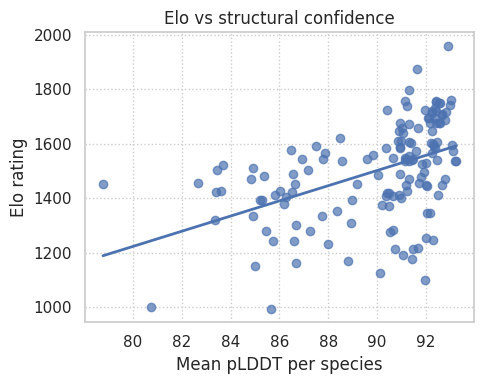

In [ ]:
# ── pLDDT ↔ Elo sanity check ──────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# 1. read the raw dataset (needed only for avg_plddt)
input_file_path = "/content/proteins_full_phylum_fixed_with_TM.csv"  # Your input dataset
input_df = pd.read_csv(input_file_path)

# 2. build a species-level Elo table from your results_long DataFrame
elo_df = (
    results_long[[species_column, "rating"]]
    .groupby(species_column)["rating"]
    .mean()
    .reset_index()
    .rename(columns={"rating": "elo_rating"})
)

# 3. average pLDDT per species
plddt_df = (
    input_df.dropna(subset=["avg_plddt"])
            .groupby(species_column)["avg_plddt"]
            .mean()
            .reset_index()
)

# 4. merge and clean
merged = pd.merge(elo_df, plddt_df, on=species_column, how="inner")

# 5. correlation statistics
pear_r, pear_p   = stats.pearsonr(merged["avg_plddt"], merged["elo_rating"])
spear_r, spear_p = stats.spearmanr(merged["avg_plddt"], merged["elo_rating"])

print(f"Pearson  r = {pear_r:.3f} (p = {pear_p:.2e})")
print(f"Spearman ρ = {spear_r:.3f} (p = {spear_p:.2e})")

# 6. scatter plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(merged["avg_plddt"], merged["elo_rating"], alpha=0.7)
m, b = np.polyfit(merged["avg_plddt"], merged["elo_rating"], 1)
x = np.array([merged["avg_plddt"].min(), merged["avg_plddt"].max()])
ax.plot(x, m * x + b, linewidth=2)
ax.set_xlabel("Mean pLDDT per species")
ax.set_ylabel("Elo rating")
ax.set_title("Elo vs structural confidence")
ax.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 7. optional: save figure and stats for the paper / report
out_dir = Path("results") / "plddt_vs_elo"
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "plddt_vs_elo_scatter.png", dpi=300)

merged.to_csv(out_dir / "plddt_vs_elo_data.csv", index=False)

If |r| < 0.2 and p > 0.05 – pLDDT has little influence:

“Structural confidence (pLDDT) is not predictive of species Elo scores (Pearson r = … , p = …).”

If |r| ≈ 0.3-0.5 – note a moderate trend and caution readers.

If |r| > 0.5 – emphasise that low-confidence structures substantially depress Elo ratings and should be considered when comparing species.

In [ ]:
# --- linear de-bias ----------------------------------------------------------
import pandas as pd
import numpy as np

# merged already contains avg_plddt and elo_rating from the previous cell
plddt_cent = merged["avg_plddt"] - merged["avg_plddt"].mean()
beta, _ = np.polyfit(plddt_cent, merged["elo_rating"], 1)   # slope only
merged["elo_adjusted"] = merged["elo_rating"] - beta * plddt_cent

print(f"Slope β = {beta:.2f} Elo / pLDDT unit")
merged[["species", "elo_rating", "elo_adjusted"]].head()

# optional: save
merged.to_csv("results/plddt_vs_elo/elo_debiased.csv", index=False)

Slope β = 27.84 Elo / pLDDT unit


In [ ]:
# inspect the actual weight distribution
# Recompute normalized_data in a cell
input_df = pd.read_csv(input_file_path)
score_columns = [

        'ESM2_15B_pppl_score','carp640M_mean_logp','proteinmpnn_score','esmif_score', 'mif_score','mifst_score','sequence_score_20'

]
normalized_data = normalize_scores(input_df, score_columns, protein_column)

weights = (normalized_data["avg_plddt"] / 100) ** 2          # self-weight
pair_w  = np.quantile(weights, [0.1, 0.25, 0.5, 0.75, 0.9])
print("Single-protein weight quantiles:", pair_w)

# estimate typical match weight (geometric mean of two self-weights)
geom_pair = np.sqrt(np.outer(weights, weights)).flatten()
q = np.quantile(geom_pair, [0.1, 0.25, 0.5, 0.75, 0.9])
print("Match weight quantiles:", q)

Single-protein weight quantiles: [0.59041836 0.74600951 0.84038543 0.90355193 0.93017541]
Match weight quantiles: [0.63395458 0.73225333 0.81943541 0.87256495 0.90691421]


# Save

In [ ]:
import os
import zipfile
import zlib # Import zlib

# Define the base directory for the output files
base_dir = "elo_analysis_results"

# Define the name for the zip file
zip_filename = "elo_analysis_results.zip"

# Create the zip file
# Use zipfile.ZIP_DEFLATED for compression
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the base directory and add all files to the zip file
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Add the file to the zip file, preserving the directory structure
            zipf.write(file_path, os.path.relpath(file_path, base_dir))

print(f"Successfully created {zip_filename}")

Successfully created elo_analysis_results.zip
